# Test-Ponicode type prediction

## Imports and pre-requirements

In [1]:
import pickle
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Data-Visualisation and plan

In [2]:
#Data visualisation (unpickle file)
with open('anulap.pkl', 'rb') as f:
    my_depickler = pickle.Unpickler(f)
    datas = my_depickler.load()
#print(datas)

#Check the type of data for each column of the DataFrame
# df = pd.DataFrame(datas, columns= ['function', 'types','project'])
# row = df.values.tolist()
# for item in row:
# 	print(item)
# 	print()
# 	input()



## Pre-Processing the datas

In [3]:
def pre_process(datas):
    #Get the vocabulary and the parameter to match to each type (usage of set to not have the same word twice)
    vocabulary = set()
    words_to_predict = []
    X_set = []
    voc = datas['function'].tolist()
    #Parse the functions one by one
    for function in voc :
        #Get the parameters of the functions in a list
        splited_function = function.split("\n")
        parameter_of_actual_function = []
        start,end = 0,0
        #Obtain the parameters which are contained in the parenthesis of the function name
        for character in splited_function[0]:
            if character == "(":
                start = splited_function[0].find('(')
            if character == ")":
                end = splited_function[0].find(')')
            if start != 0 and end != 0:
                #cleans out the comments in the parameters (/* */) and the auto assign type
                parameters = splited_function[0][start+1:end]
                cleaned_param = re.sub(r'/.+?/', '', parameters)
                cleaned_param_2 = cleaned_param.split(":")
                cleaned_param_2 = str(cleaned_param_2[0])
                parameter_of_actual_function.append(cleaned_param_2)
                break
        #Get the parameters of the actual function into a string type and add it to the final list
        joined ="".join(parameter_of_actual_function).replace(" ","").split(",")
        words_to_predict.extend(joined)

        #Get the totality of the vocabulary to help with the construction of the word embeddings
        splited_function_2 = re.split(r'[.\s(),]\s*', function)
        X_set.append(splited_function_2)
        for element in splited_function_2:
            vocabulary.add(element)

    # print(words_to_predict)
    # print(X_set)

    #Get the gold values from the type column of the dataframe
    Y_set = []
    types = datas['types'].tolist()
    for set_type in types:
        Y_types = set_type.split(",")
        for one_elem in Y_types:
            Y_set.append(one_elem)
            
    #Assign each parameter to it's gold type (for debug purpose to see if each parameter has it's own type)
    # gold_values = zip(words_to_predict,Y_set)
    # for one_gold in gold_values:
    # 	print(one_gold)
    # 	input()

    #Turn the current vocabulary to it's w2idx so that each parameter has it's own index
    word2idx = {word: ind for ind, word in enumerate(vocabulary)}

    #Get all the existing labels into a set and assign one index to each label
    labels = []
    for items in types:
        all_type = [item for item in items.split(',')]
        for final_type in all_type:
            labels.append(final_type)
    labels = set(labels)
    labels2idx = {label: ind for ind, label in enumerate(labels)}
    print(labels2idx)

    #Encode every parameter with it associated index in the vocabulary
    X_encoded_set = []
    for function in words_to_predict:
        encoded_function = [word2idx[function]]
        X_encoded_set.append(encoded_function)

    #Encode every gold target to it's associated index
    Y_encoded_set = []
    for types in Y_set:
        encoded_type = [labels2idx[types]]
        Y_encoded_set.append(encoded_type)

    return X_encoded_set , Y_encoded_set, labels2idx, word2idx, labels, vocabulary
        
#Reconstruct the datas with the encoded X and Y to realise a train and test set 
#(If more time split into train - test - dev) for more accurate training
X_encoded_set , Y_encoded_set, labels2idx, word2idx, labels, vocabulary = pre_process(datas)
reconstructed_encod_datas = list(zip(X_encoded_set,Y_encoded_set))
train, test = train_test_split(reconstructed_encod_datas, random_state=42, test_size=0.20, shuffle=True)

{'array': 0, 'string': 1, 'function': 2, 'boolean': 3, 'object': 4, 'number': 5}


## Application of the model

In [4]:
#LSTM model with embedding layer and one linear layer for output
class LSTM(torch.nn.Module) :
    """
    Neural Network of type LSTM to predict the type of parameter of a function
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim    = hidden_dim
        self.embedding_dim = embedding_dim

        #declare layers of the models
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False)
        self.out = nn.Linear(hidden_dim, len(labels2idx))
        self.dropout = nn.Dropout(0.2)
        
        self.min_loss = 99999999
        self.B_model = None
        
    def forward(self, X):
        """
        Apply forward to the data
        :param X: index representation of a word
        :type X: list
        """
        #apply forward to the inputs and get the prediction as a list of probabilities
        emb_datas = torch.LongTensor(X)
        embedded = self.embeddings(emb_datas)
        embedded = self.dropout(embedded)
        lstm_out, (hidden, cell) = self.lstm(embedded.unsqueeze(0))
        return self.out(hidden)

    def train(self,train,epochs,lr=0.001):
        """
        Train the model
        :param train: list of parameters and gold
        :type train: list
        
        :param epochs: number of epochs to train the model
        :type epochs: int
        
        :param lr: learning rate of the optimize
        :lr: float
        """
        #use loader so both of X and Y are tensors
        train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle =True)
        
        #CrossEntropyLoss is the most used for multiclass prediction and combine softmax and NLLLoss
        loss_func  = nn.CrossEntropyLoss() 
        optimizer  = optim.Adam(self.parameters(), lr=lr)
        #For shallow networks but is much slower 
        #optimizer  = optim.SGD(self.parameters(), lr=0.01)
        
        for e in range(epochs):
            train_loss = 0.0
            correct = 0
            for x_train,y_train in train_loader:
                self.zero_grad()
                prob_train      = self.forward(x_train)
                predicted       = torch.argmax(prob_train)
                loss            = loss_func(prob_train.squeeze(0),y_train[0])
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                if (predicted == y_train[0]):
                    correct += 1 
                    
            print("Epoch:", e, "train_loss:" , train_loss/len(train), "accuracy:" , correct/len(train))

            #compare loss of all epochs and take the best model
            if train_loss < self.min_loss : 
                    self.min_loss = train_loss
                    self.B_model = self.state_dict()
                    
    def predict(self,test):
        """
        Apply model to the test set
        :param test: list of parameters and gold
        :type test: list
        """
        
        test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle =True)
        correct = 0
        predictions = []
        y_true = []
        for x_test,y_test in test_loader:
            prob_test = self.forward(x_test)
            predicted = torch.argmax(prob_test)
            if (predicted == y_test[0]):
                correct += 1
            predictions.append(int(predicted))
            y_true.append(int(y_test[0]))
                    
        print("Accuracy_test:", correct/len(test))
        return predictions, y_true

            
            
vocab_size = len(vocabulary)
emb_dim = 5
hidden_dim = 5
lstm = LSTM(vocab_size,emb_dim,hidden_dim)
lstm.train(train,30)
#saving the best model in the folder
torch.save(lstm.B_model, "BestModel")

Epoch: 0 train_loss: 1.558499941822715 accuracy: 0.3248512888301388
Epoch: 1 train_loss: 1.3679984154454226 accuracy: 0.4170522141440846
Epoch: 2 train_loss: 1.2588832831910153 accuracy: 0.5196629213483146
Epoch: 3 train_loss: 1.1608808289219854 accuracy: 0.576668869795109
Epoch: 4 train_loss: 1.0791979171027923 accuracy: 0.6052544613350959
Epoch: 5 train_loss: 1.011882694518121 accuracy: 0.635822868473232
Epoch: 6 train_loss: 0.9531571426452246 accuracy: 0.6566424322538004
Epoch: 7 train_loss: 0.9102312723132834 accuracy: 0.6754791804362195
Epoch: 8 train_loss: 0.872774643023909 accuracy: 0.6906807666886979
Epoch: 9 train_loss: 0.8303484339317798 accuracy: 0.7085261070720423
Epoch: 10 train_loss: 0.8052465478098358 accuracy: 0.7186054196959683
Epoch: 11 train_loss: 0.7644034122207349 accuracy: 0.7352941176470589
Epoch: 12 train_loss: 0.7425686194514025 accuracy: 0.7475214805023133
Epoch: 13 train_loss: 0.712689652523458 accuracy: 0.7594183740912095
Epoch: 14 train_loss: 0.695664450965

## Matrix representation of test

Accuracy_test: 0.7587574355584931


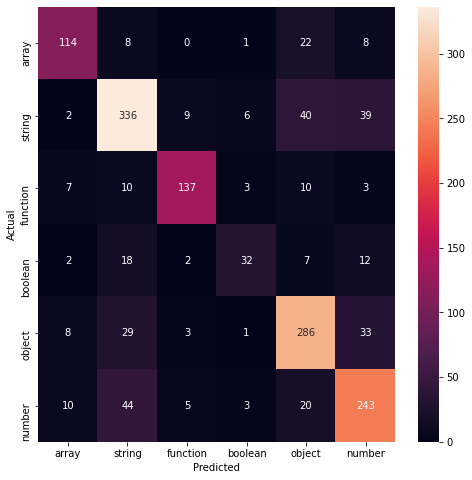

In [5]:
#Load the model to apply to the test set
lstm.load_state_dict(torch.load("BestModel"))
predictions,y_true = lstm.predict(test)
cfs_m = confusion_matrix(y_true,predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cfs_m, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Ideas of improvements and comments